## ==================== Libraries ====================

In [1]:
# Determinadas
import pandas
import numpy as np
import matplotlib.pyplot as plt
import math
import random

# Procesamiento de imágenes
from PIL import Image

### Global Variables

In [2]:
cont_call_fo = 0

## <br><br><br>==================== Functions ====================

### Objective Function

In [3]:
def objectiveFunction(sudoku): # 100 fitness máximo
    # Aumentar contador.
    global cont_call_fo
    cont_call_fo +=1
    
    # Variable de fitness.
    fitness = 100
    
    # Filas y columnas.
    for i in range(9):
        # Obtener fila.
        row = sudoku[i,:]
        
        # Obtener columna.
        col = sudoku[:,i]
        
        # Duplicados de las filas.
        duplicates = [x for x in row if list(row).count(x) > 1]
        row_duplicates = list(set(duplicates))
        
        # Duplicados de las columnas.
        duplicates = [x for x in col if list(col).count(x) > 1]
        col_duplicates = list(set(duplicates))
        
        # Bajar fitness.
        if len(row_duplicates) > 0:
            fitness -= len(row_duplicates)
        if len(col_duplicates) > 0:
            fitness -= len(col_duplicates)
    
    # Regiones.
    for i in range(0,9,3):
        for j in range(0,9,3):
            # Obtener región del sudoku.
            region = [sudoku[x][y] for x in range(i,i+3) for y in range(j,j+3)]
            
            # Duplicados de las filas.
            duplicates = [x for x in region if list(region).count(x) > 1]
            region_duplicates = list(set(duplicates))
            
            # Bajar fitness.
            if len(region_duplicates) > 0:
                fitness -= len(region_duplicates)
    
    return fitness

### Check Repeated Numbers Function

In [4]:
def checkRepeatedNumbers(sudoku):
    # Filas.
    for i in range(9):
        # Obtener fila.
        row = sudoku[i,:]
        
        # Obtener columna.
        col = sudoku[:,i]
        
        # Duplicados de las filas.
        duplicates = [x for x in row if list(row).count(x) > 1]
        row_duplicates = list(set(duplicates))
        
        # Duplicados de las columnas.
        duplicates = [x for x in col if list(col).count(x) > 1]
        col_duplicates = list(set(duplicates))
        
        print("Row " + str(i+1) + ": " + str( row_duplicates ) )
        print("Col " + str(i+1) + ": " + str( col_duplicates ) )
        
    # Regiones.
    for i in range(0,9,3):
        for j in range(0,9,3):
            # Obtener región del sudoku.
            region = [sudoku[x][y] for x in range(i,i+3) for y in range(j,j+3)]
            
            # Duplicados de las filas.
            duplicates = [x for x in region if list(region).count(x) > 1]
            region_duplicates = list(set(duplicates))
              
            print("Region (" + str(i//3 + 1) + "," + str(j//3 + 1) + "): " + str( region_duplicates ) )

### Random Element

In [5]:
def getRandomizeElement(sudoku, padding_indexes):
    # Copiar sudoku.
    newSudoku = sudoku.copy()
    
    # Rango de valores.
    values = range(1,10)
    
    for i in range(9):
        # Obtener fila.
        row = sudoku[i,:]
        
        # Obtener la diferencia simétrica (valores que faltan).
        padding_values = np.setdiff1d(values, row)
        
        # Permutar valores.
        padding_values = np.random.permutation(padding_values)
        
        # Añadir valores.
        newSudoku[i,padding_indexes[i]] = padding_values
        
    return newSudoku

In [6]:
# def getRandomizeElement(sudoku, padding_indexes):
#     # Copiar sudoku.
#     newSudoku = sudoku.copy()
    
#     # Rango de valores.
#     values = range(1,10)
    
#     for i in range(9):
#         # Añadir valores.
#         newSudoku[i,padding_indexes[i]] = np.random.choice(range(1,10), len(padding_indexes[i]), replace=True)
        
#     return newSudoku

### <br><br><br><br>Genetic Algorithm

#### Selection functions

In [7]:
def parentsSelectionByTournament(k, populationFitness):
    # Obtener el tamaño de la población.
    N = len(populationFitness)
    
    # Matriz para guardar la población del torneo.
    newPopulation = np.zeros(k, dtype=int)

    # Rellenar matriz con nuevos individuos.
    for i in range(k):
        while True:
            # Generar número random.
            r = random.randint(0, N-1)
            
            # Si todavía no ha sido seleccionado dicho individuo.
            if r not in newPopulation:
                # Agregar individuo.
                newPopulation[i] = r

                break
        
    # El mejor individuo.
    fittestIndividual = newPopulation[ np.argmax(populationFitness[newPopulation]) ]
    
    return fittestIndividual

In [8]:
def parentsSelectionByRoulette(k, populationFitness):
    # Obtener el tamaño de la población.
    N = len(populationFitness)
    
    # Lista para guardar las proporciones de cada individuo.
    proportionsRange = np.zeros((N,2))
    
    # Total suma de fitness.
    totalFitness = np.sum(populationFitness)
        
    # Calcular ruleta.
    roulette = np.cumsum(populationFitness / totalFitness)

    # Matriz para guardar la población de la ruleta.
    newPopulation = np.zeros(k, dtype=int)
    
    # Rellenar 
    for i in range(k):
        while True:
            # Generar un número random entre 0 y 1.
            randomNumber = np.random.uniform(0, 1, 1)

            # Checar qué rango es.
            j = 0
            while roulette[j] < randomNumber:
                j += 1
                
            # Si todavía no ha sido seleccionado dicho individuo.
            if j not in newPopulation:
                # Agregar individuo.
                newPopulation[i] = j

                break
                    
    # El mejor individuo.
    fittestIndividual = newPopulation[ np.argmax(populationFitness[newPopulation]) ]
    
    return fittestIndividual

#### Crossover functions

In [9]:
def simpleCrossover(Pr, k, populationList, populationFitness):
    # Obtener el tamaño de la población.
    N = len(populationList)
    
    # Matriz para guardar la nueva población.
    newPopulation = np.zeros_like(populationList)
    
    for i in range(N):
        # Generar un número random entre 0 y 1.
        r = np.random.uniform(0, 1, 1)
        
        # Si el número random es menor que la Pr.
        if r < Pr:
            # Seleccionar padres.
            parent1 = populationList[ parentsSelectionByTournament(k, populationFitness) ]
            parent2 = populationList[ parentsSelectionByTournament(k, populationFitness) ]
            # parent1 = populationList[ parentsSelectionByRoulette(k, populationFitness) ]
            # parent2 = populationList[ parentsSelectionByRoulette(k, populationFitness) ]
            
            # Dividir en partes a los papás.
            part1 = parent1[:len(parent1)//2]
            part2 = parent2[len(parent2)//2:]
            
            # Obtener al hijo.
            offspring = np.concatenate((part1,part2), axis=0)
                   
            # Agregar a la población.      
            newPopulation[i] = offspring
        else:
            # Seleccionar padre.
            parent = populationList[ parentsSelectionByTournament(k, populationFitness) ]
            # parent = populationList[ parentsSelectionByRoulette(k, populationFitness) ]
            
            # Agregar a la población.      
            newPopulation[i] = parent
        
    return newPopulation

In [10]:
def partialCrossover(Pr, k, populationList, populationFitness):
    # Obtener el tamaña de la población.
    N = len(populationList)
    
    # Matriz para guardar la nueva población.
    newPopulation = np.zeros_like(populationList)
    
    for i in range(N):
        # Generar un número random entre 0 y 1.
        r = np.random.uniform(0, 1, 1)
        
        # Si el número random es menor que la Pr.
        if r < Pr:
            # Seleccionar padres.
            parent1 = populationList[ parentsSelectionByTournament(k, populationFitness) ]
            parent2 = populationList[ parentsSelectionByTournament(k, populationFitness) ]
            # parent1 = populationList[ parentsSelectionByRoulette(k, populationFitness) ]
            # parent2 = populationList[ parentsSelectionByRoulette(k, populationFitness) ]
            
            # Obtener la división
            exactDivision = len(parent1)//3
            
            # Dividir en partes a los papás.
            part1 = parent2[:exactDivision]
            part2 = parent1[exactDivision:exactDivision*2]
            part3 = parent2[exactDivision*2:]
            
            # Obtener al hijo.
            offspring = np.concatenate((part1,part2,part3), axis=0)
                            
            # Agregar a la población.      
            newPopulation[i] = offspring
        else:
            # Seleccionar padre.
            parent = populationList[ parentsSelectionByTournament(k, populationFitness) ]
            # parent = populationList[ parentsSelectionByRoulette(k, populationFitness) ]

            # Agregar a la población.      
            newPopulation[i] = parent
    
    return newPopulation

#### Mutation function

In [11]:
def randomMutation(Pm, populationList, padding_indexes):
    # Obtener el tamaño de la población.
    N = len(populationList)
    
    for i in range(N):
        # Generar un número random entre 0 y 1.
        r = np.random.uniform(0, 1, 1)

        # Si el número random es menor que la Pm.
        if r < Pm:
            # Número random a poner.
            random_number = random.randint(1, 9)
            
            # Seleccionar índice random de fila.
            random_row_index = random.randint(0, 9-1)
            
            # Seleccionar índice random de columnas.
            random_col_index = np.random.choice(padding_indexes[random_row_index], 1)
            
            # Colocar número random.
            populationList[i, random_row_index, random_col_index[0]] = random_number
            
    return populationList

In [12]:
def swapMutation(Pm, populationList, padding_indexes):
    # Obtener el tamaño de la población.
    N = len(populationList)
    
    for i in range(N):
        # Generar un número random entre 0 y 1.
        r = np.random.uniform(0, 1, 1)

        # Si el número random es menor que la Pm.
        if r < Pm:
            # Seleccionar índice random de fila.
            random_row_index = random.randint(0, 9-1)
            
            # Seleccionar índices random de columnas.
            random_col_indexes = np.random.choice(padding_indexes[random_row_index], 2, replace=False)
            
            # Swap.
            aux = populationList[i, random_row_index, random_col_indexes[0]]
            populationList[i, random_row_index, random_col_indexes[0]] = populationList[i, random_row_index, random_col_indexes[1]]
            populationList[i, random_row_index, random_col_indexes[1]] = aux
            
    return populationList

#### Elite functions

In [13]:
def getElite(populationFitness):
    # Obtener el tamaño de la población.
    N = len(populationFitness)
    
    # Obtener el índice del mejor.
    index = np.argmax(populationFitness)
            
    return index

#### Main function

In [14]:
def geneticAlgorithm(N, G, Pr, Pm, sudoku):
    # Lista de índices por rellenar en el sudoku.
    padding_indexes = []
    
    # Obtener índices por rellenar en el sudoku.
    for i in range(9):
        # Obtener la fila.
        row = sudoku[i,:]

        # Obtener índices de valores que faltan por rellenar.
        row_indexes = np.where(row == 0)[0]
        
        # Añadir a la lista.
        padding_indexes.append(row_indexes)
            
    # 'Listas' a utilizar.
    populationList = np.zeros((N, 9,9), dtype=int) # Lista de la población.
    populationFitness = np.zeros(N) # Lista de las aptitudes de la población.
        
    # Crear la población inicial.
    for i in range(N):
        # Obtener individuo.
        populationList[i] = getRandomizeElement(sudoku, padding_indexes)
        
        # Calcular la aptitud del individuo i.
        populationFitness[i] = objectiveFunction(populationList[i])
        
    # Obtener el elite.
    eliteIndex = getElite(populationFitness)
    elite = [ populationList[eliteIndex], populationFitness[eliteIndex] ]
    
    # Elite previo.
    prevElite = elite
    
    # Generaciones.
    genIter = 0
    while genIter < G:
        # Aplicar crossover
        k = 5
        # populationList = simpleCrossover(Pr, k, populationList.copy(), populationFitness.copy())
        populationList = partialCrossover(Pr, k, populationList.copy(), populationFitness.copy())

        # Aplicar mutación.
#         populationList = randomMutation(Pm, populationList.copy(), padding_indexes)
        populationList = swapMutation(Pm, populationList.copy(), padding_indexes)
        
        # Calcular la aptitud de la población.
        for i in range(N):
            populationFitness[i] = objectiveFunction(populationList[i])
            
        # Obtener el elite.
        eliteIndex = getElite(populationFitness)
        elite = [ populationList[eliteIndex], populationFitness[eliteIndex] ]
        
#         print("Gen", genIter, "\n", elite[0], elite[1], "\n")
        # Si el elite actual es mejor que el global.
        if elite[1] > prevElite[1]:
            # Cambiar al mejor elite global.
            prevElite = elite
            
            print("Gen:" + str(genIter) + ", Mejora: " + str(prevElite[1]))
            
            # Si el fitness del mejor elite global obtuvo puntaje perfecto. 
            if prevElite[1] == 100:
#                 print("Gen:" + str(genIter) + ", Mejora: " + str(prevElite[1]))
                return prevElite
            
        # Aumentar iterador.
        genIter += 1
            
    print("Gen:" + str(genIter) + ", Mejora: " + str(prevElite[1]))
    return prevElite

### <br><br><br><br>Plot solution function

In [15]:
def plotSolution(solution, fixed_values):
    # Cargar imagen.
    sudoku_scheme = Image.open(r"Datasets/Sudoku_Scheme.jpg")
        
    # Mostrar imagen.
    plt.figure(figsize=(15,5))
    
    # Colocar números.
    for i in range(9):
        for j in range(9):
            # Obtener posiciones en 'x' y en 'y'.
            x = j * 90 + 80
            y = i * 90 + 90

            if fixed_values[i,j] == 0:
                plt.text(x,y,str(solution[0][i,j]), fontsize="x-large", color="blue")
            else:
                plt.text(x,y,str(fixed_values[i][j]), fontsize="x-large", color="black")
    
    ax = plt.gca() # Obtener ejes.
    ax.get_xaxis().set_visible(False) # Ocultar eje 'x'.
    ax.get_yaxis().set_visible(False) # Ocultar eje 'y'.

    plt.imshow(sudoku_scheme, cmap="gray") # Mostrar imagen.
    
    # Título de la imagen según sea el fitness.
    if solution[1] == 100:
        plt.title("Fitness: " + str(solution[1]) + ", SOLUTION FOUND")
    else:
        plt.title("Fitness: " + str(solution[1]) + ", SOLUTION NOT FOUND")
    plt.show()

## <br><br><br><br><br><br><br><br>==================== Main ====================

### Load dataset

In [30]:
# Dirección del dataset.
path = 'Datasets/Sudoku_1.csv'

# Leer documento .csv.
sudoku = pandas.read_csv(path).values

# Sudoku a np array.
sudoku = np.asarray(sudoku)

# Impresión de datos.
print(sudoku)

[[0 0 0 0 0 0 0 0 8]
 [0 0 0 3 9 0 0 4 1]
 [0 4 0 5 0 0 0 0 0]
 [1 0 4 9 8 5 0 0 3]
 [8 0 0 0 2 0 1 0 0]
 [2 0 0 6 1 0 8 0 4]
 [4 8 7 0 5 0 3 0 6]
 [3 0 0 0 0 0 0 0 9]
 [0 2 0 1 0 0 0 0 7]]


### Resolve

In [31]:
# Variables a utilizar.
N = 200
G = 1000
Pr = 0.8
Pm = 0.3
cont_call_fo = 0
    
# Llamar función del algoritmo genético.
elite = geneticAlgorithm(N, G, Pr, Pm, sudoku)

Gen:0, Mejora: 74.0
Gen:1, Mejora: 76.0
Gen:4, Mejora: 77.0
Gen:5, Mejora: 78.0
Gen:6, Mejora: 79.0
Gen:8, Mejora: 80.0
Gen:10, Mejora: 81.0
Gen:12, Mejora: 84.0
Gen:14, Mejora: 86.0
Gen:17, Mejora: 88.0
Gen:18, Mejora: 90.0
Gen:24, Mejora: 92.0
Gen:27, Mejora: 94.0
Gen:32, Mejora: 95.0
Gen:35, Mejora: 96.0
Gen:50, Mejora: 98.0
Gen:70, Mejora: 100.0


### Show results

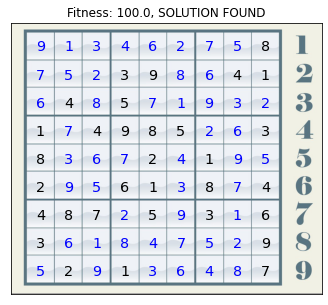

Se llamó a la función objetivo un total de: 14400


In [32]:
# Plotear solución.
plotSolution(elite.copy(), sudoku.copy())

# Imprimir la cantidad de veces que fue llamada la función objetivo.
print("Se llamó a la función objetivo un total de: " + str(cont_call_fo))

In [33]:
# Checar dónde hay valores repetidos y cuáles son.
checkRepeatedNumbers(elite[0])

Row 1: []
Col 1: []
Row 2: []
Col 2: []
Row 3: []
Col 3: []
Row 4: []
Col 4: []
Row 5: []
Col 5: []
Row 6: []
Col 6: []
Row 7: []
Col 7: []
Row 8: []
Col 8: []
Row 9: []
Col 9: []
Region (1,1): []
Region (1,2): []
Region (1,3): []
Region (2,1): []
Region (2,2): []
Region (2,3): []
Region (3,1): []
Region (3,2): []
Region (3,3): []
